# Processing Sentiment Scores from Output Files

In [49]:
# Imports
import json
import numpy as np
import matplotlib.pyplot as plt

In [50]:
model_name = 'gpt2-medium'

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

score_file = f"./data/{model_name}-out.json"
with open(score_file, 'r') as f:
    raw_scores = json.load(f)

scores = {'O': {'scores': []},
        'C': {'scores': []},
        'E': {'scores': []},
        'A': {'scores': []},
        'N': {'scores': []}
        }
metadata = {}

for question_number, question_dict in raw_scores.items():
    metadata[question_number] = {}
    responses = question_dict['responses']
    # Average across the responses first - store this as metadata
    avg_responses = []
    for response in responses:
        avg_responses.append(response['score'])
    avg = np.mean(avg_responses)
    std = np.std(avg_responses)
    metadata[question_number]['mean'] = avg
    metadata[question_number]['stdev'] = std

    # Append the average - change value depending on whether the response to this question should be positively or negative correlated with
    # the trait
    if response['reverse_score']:
        scores[response['domain']]['scores'].append(question_dict['question_score'] - avg)
    else:
        scores[response['domain']]['scores'].append(avg - question_dict['question_score'])

for domain, score_dict in scores.items():
    # scores[domain]['scores'] = softmax(scores[domain]['scores'])
    #print(scores[domain]['scores'])
    scores[domain]['mean'] = -1 * np.mean(scores[domain]['scores'])
    scores[domain]['stdev'] = np.std(scores[domain]['scores'])
    del scores[domain]['scores']

with open(f"./data/{model_name}-scores.json", 'w') as f:
    json.dump(scores, f, indent=4)
with open(f"./data/{model_name}-metadata.json", 'w') as f:
    json.dump(metadata, f, indent=4)

In [46]:
# Plot results on a graph
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (15,10)
def plot_checkpoint_traits(model_name: str, score_dir: str):
    with open(score_dir, 'r') as f:
        scores = json.load(f)
    
    TRAITS = ['Openness', 'Conscientiousness', 'Extroversion', 'Agreeableness', 'Neuroticism']
    y_data = []
    y_err = []
    for trait in TRAITS:
        key = trait[0]
        y_data.append(scores[key]['mean'])
        y_err.append(scores[key]['stdev'])

    positions = np.arange(len(TRAITS))
    fig, ax = plt.subplots()
    ax.bar(positions, y_data, yerr=y_err, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel("Distance from Trait")
    ax.set_xticks(positions)
    ax.set_xticklabels(TRAITS)
    ax.set_title(f"Big 5 Personality Traits of Checkpoint {model_name}")
    ax.yaxis.grid(True)

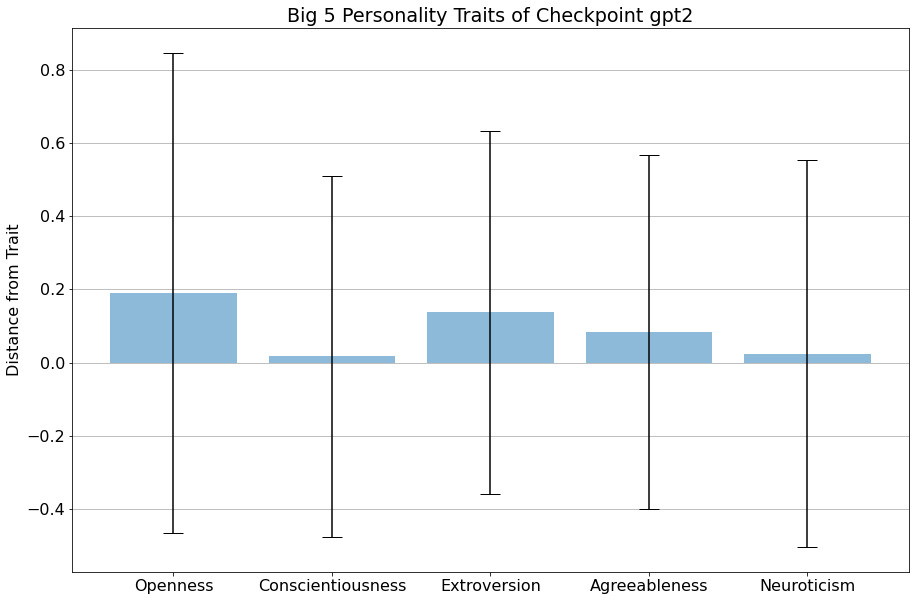

In [47]:
plot_checkpoint_traits('gpt2', './data/gpt2-scores.json')

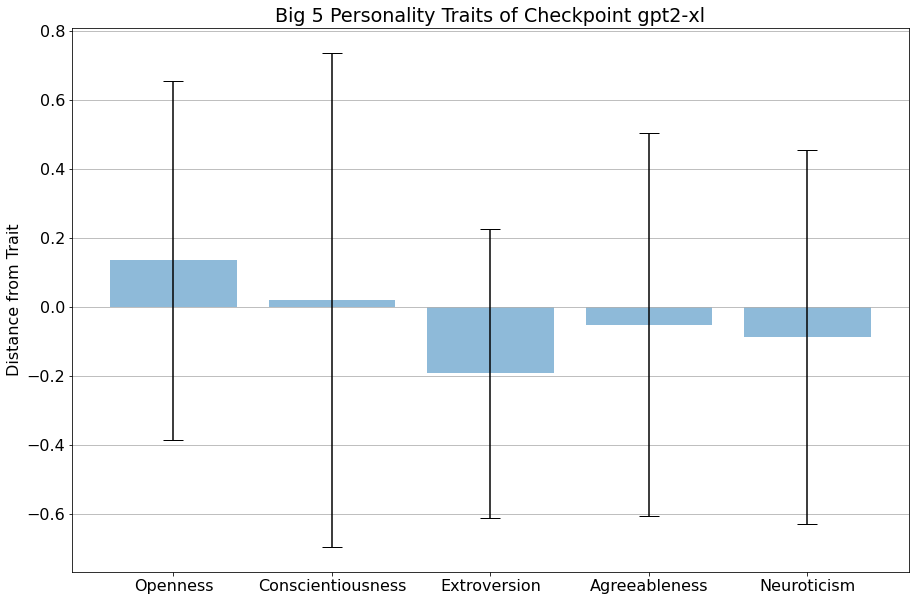

In [48]:
plot_checkpoint_traits('gpt2-medium', './data/gpt2-medium-scores.json')

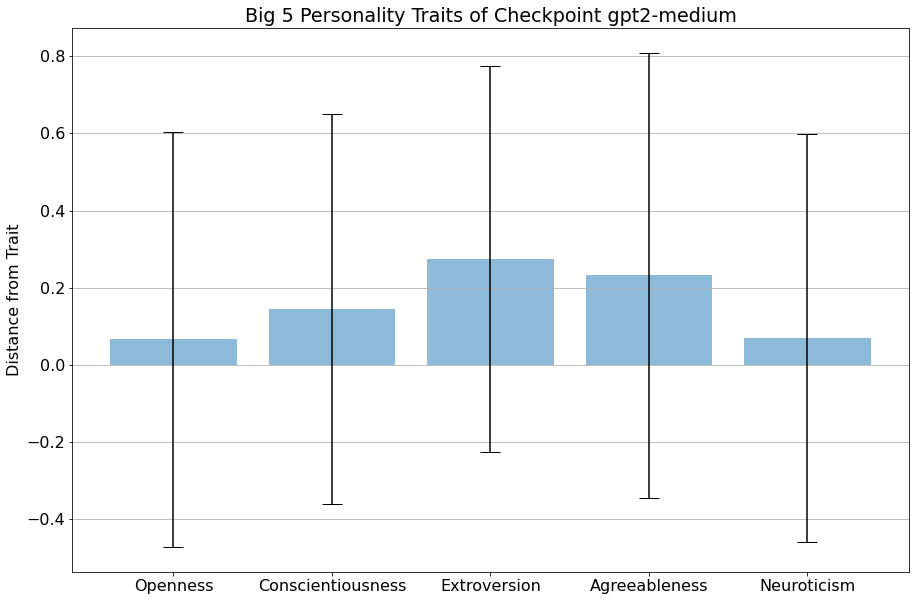

In [51]:
plot_checkpoint_traits('gpt2-xl', './data/gpt2-xl-scores.json')